In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
relax = pd.read_csv("relax.csv", dtype={"Time": np.float64})
mpi = pd.read_csv("mpi.csv", dtype={"Time": np.float64})

In [72]:
# get average of repeated runs
relax_avg = relax.groupby("N").mean().reset_index()
mpi_avg = mpi.groupby(["N", "Cores"]).mean().reset_index()

# convert time from ms to s
relax_avg["Time"] = relax_avg.Time.div(1000)
mpi_avg["Time"] = mpi_avg.Time.div(1000)

# add row for total number of elements
fn = lambda x: (int)(x.N * x.N)
relax_avg["Size"] = relax_avg.apply(fn, axis=1)
mpi_avg["Size"] = mpi_avg.apply(fn, axis=1)

# add row for flops
fn = lambda x: (9 * x.Iterations * x.N * x.N) / x.Time
relax_avg["FLOPS"] = relax_avg.apply(fn, axis=1)
mpi_avg["FLOPS"] = mpi_avg.apply(fn, axis=1)

# select only thousands
relax_small = relax_avg[relax_avg.N % 1000 == 0]
mpi_small = mpi_avg[mpi_avg.N % 1000 == 0]

In [75]:
# combine data
combined = pd.concat([relax_avg, mpi_avg])
combined = combined.fillna(0)
combined = combined.astype({"Cores": "int64"})

# add labels
fn = lambda x: "Sequential" if x.Cores == 0 else f"MPI {x.Cores} cores"
combined["Label"] = combined.apply(fn, axis=1)

# select only thousands
combined_small = combined[combined.N % 1000 == 0]

In [5]:
# set index for plotting
relax_avg.set_index("size", inplace=True)
mpi_avg.set_index("size", inplace=True)

relax_small.set_index("size", inplace=True)
mpi_small.set_index("size", inplace=True)

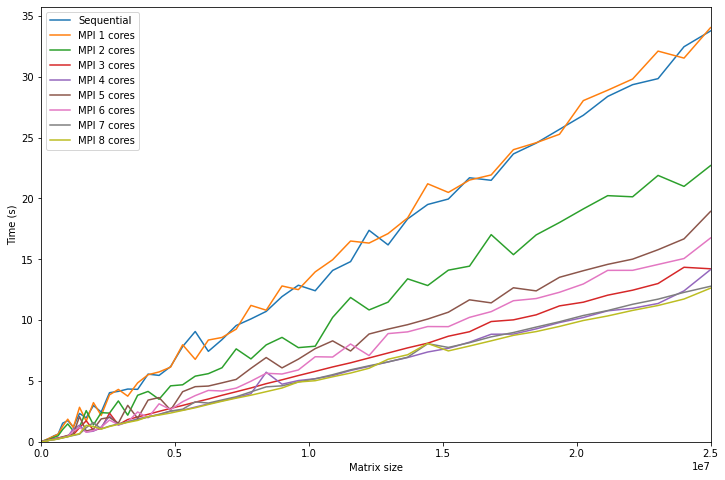

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

relax_avg["time"].plot(label="Sequential", ax=ax)
for name, group in mpi_avg.groupby("cores"):
    group["time"].plot(label=f"MPI {name} cores", ax=ax)

ax.set_xlabel("Matrix size")
ax.set_ylabel("Time (s)")
ax.set_xlim(0, 5000 * 5000)
ax.set_ylim(bottom=0)

plt.legend()
plt.show()

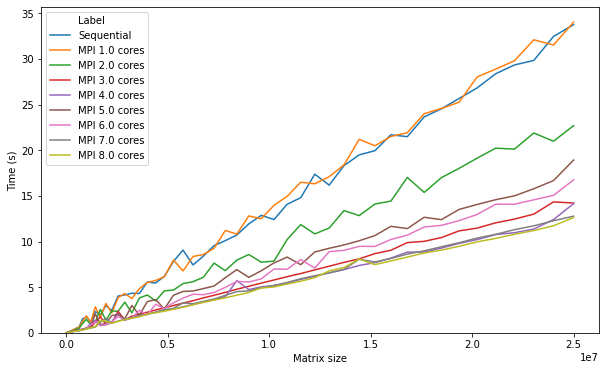

In [79]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="Size", y="Time", hue="Label", data=combined)

ax.set_xlabel("Matrix size")
ax.set_ylabel("Time (s)")
#ax.set_xlim(0, 5000 * 5000)
ax.set_ylim(bottom=0)

plt.show()

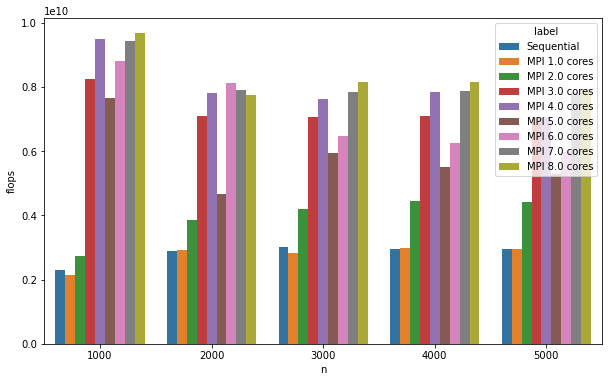

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x="n", hue="label", y="flops", data=combined_small)
plt.show()